# Lab 1 GPT code

Середнє y: 0.0012, σ(y): 0.1581
   p  q    R2_OLS    R2_RLS   SSE_OLS   SSE_RLS      AIC_OLS      AIC_RLS
0  1  1  0.557247  0.519915  5.531578  5.997983 -2242.564382 -2202.170278
1  1  2  0.559779  0.508910  5.499940  6.135474 -2237.919723 -2183.463372
2  1  3  0.604133  0.565581  4.945038  5.426619 -2283.272086 -2237.085029
3  2  1  0.612564  0.565398  4.840474  5.429744 -2301.526515 -2244.316597
4  2  2  0.616467  0.554017  4.791701  5.571929 -2304.569896 -2229.443670
5  2  3  0.619616  0.575964  4.751633  5.296920 -2301.100576 -2247.107831
6  3  1  0.618258  0.561153  4.768593  5.481924 -2301.329770 -2232.045568
7  3  2  0.619616  0.553408  4.751633  5.578675 -2301.100576 -2221.350444
8  3  3  0.619616  0.574289  4.751633  5.317842 -2299.100576 -2243.148638


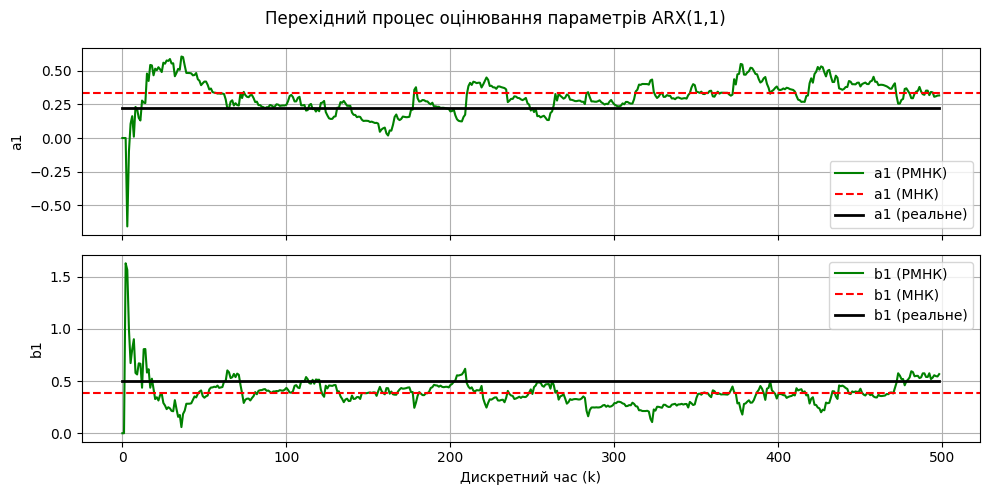

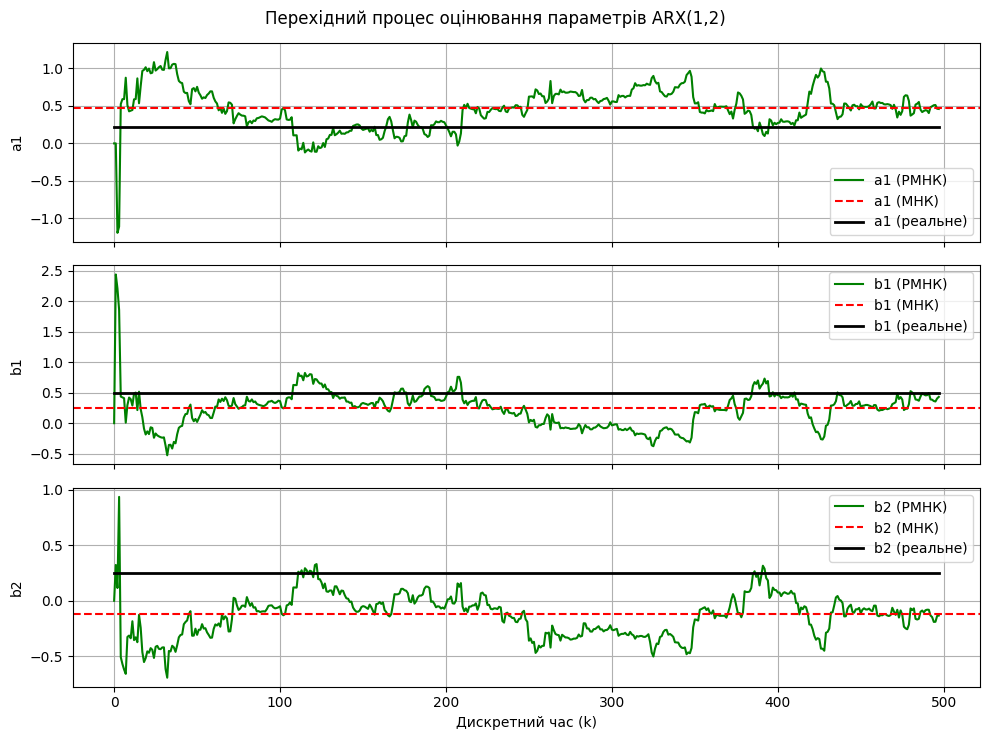

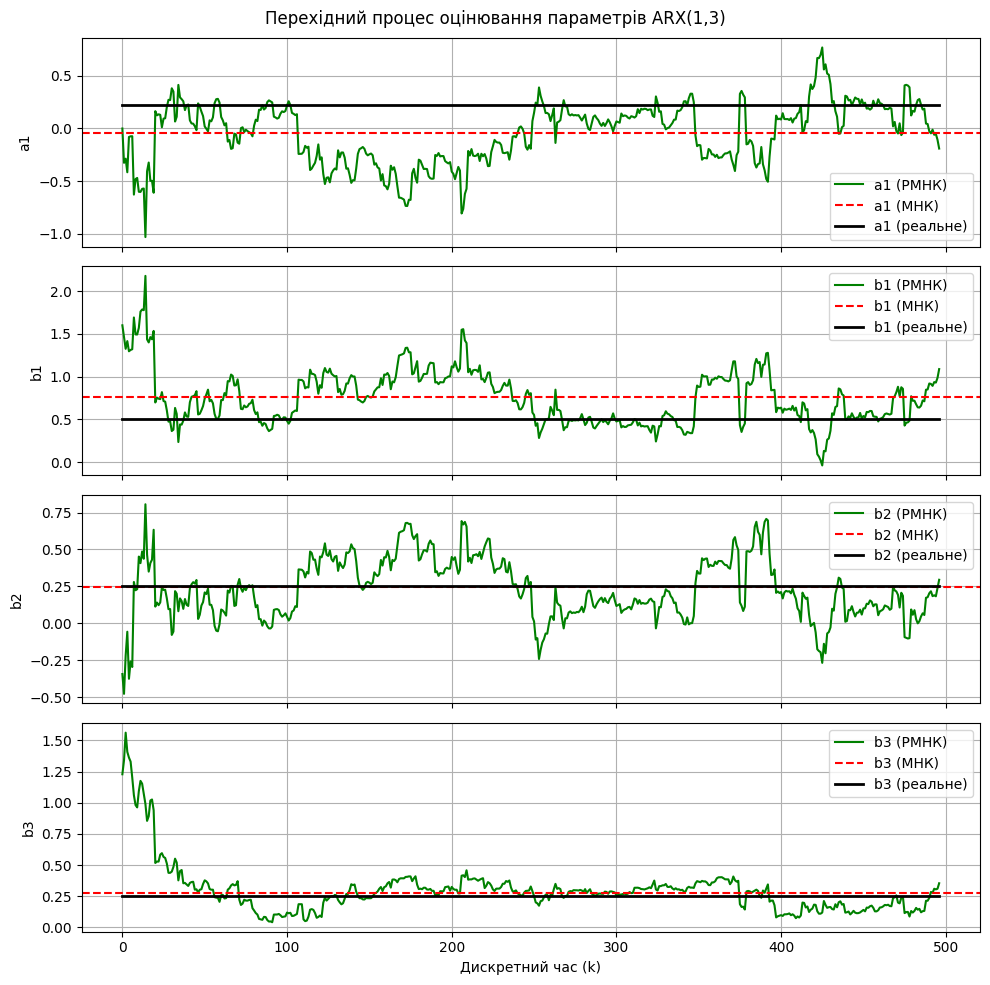

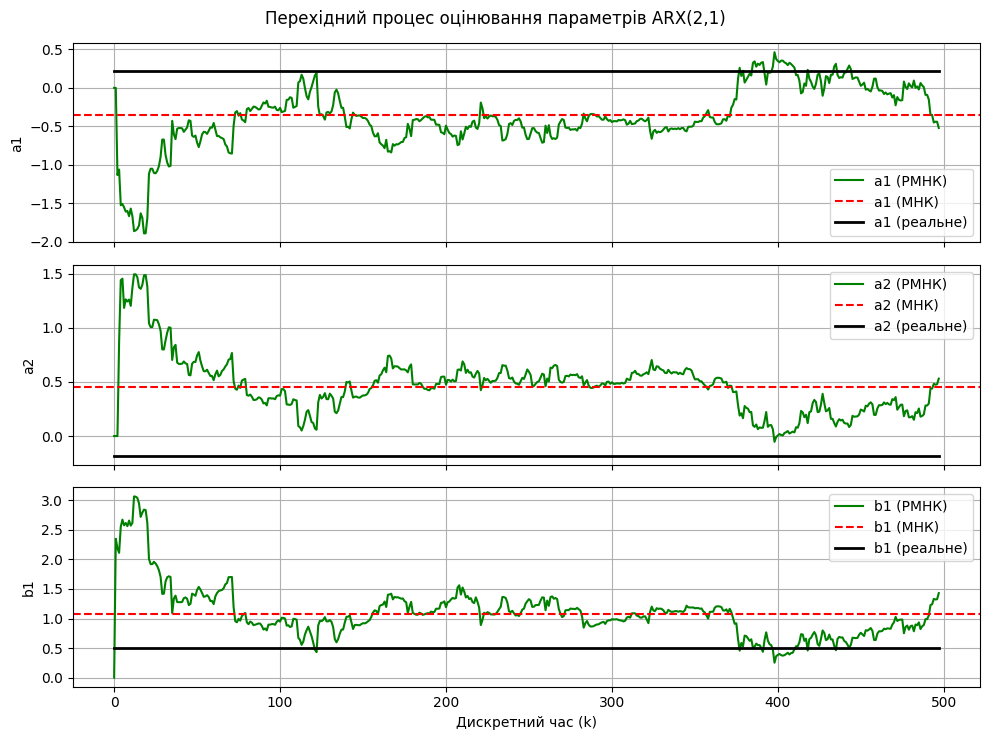

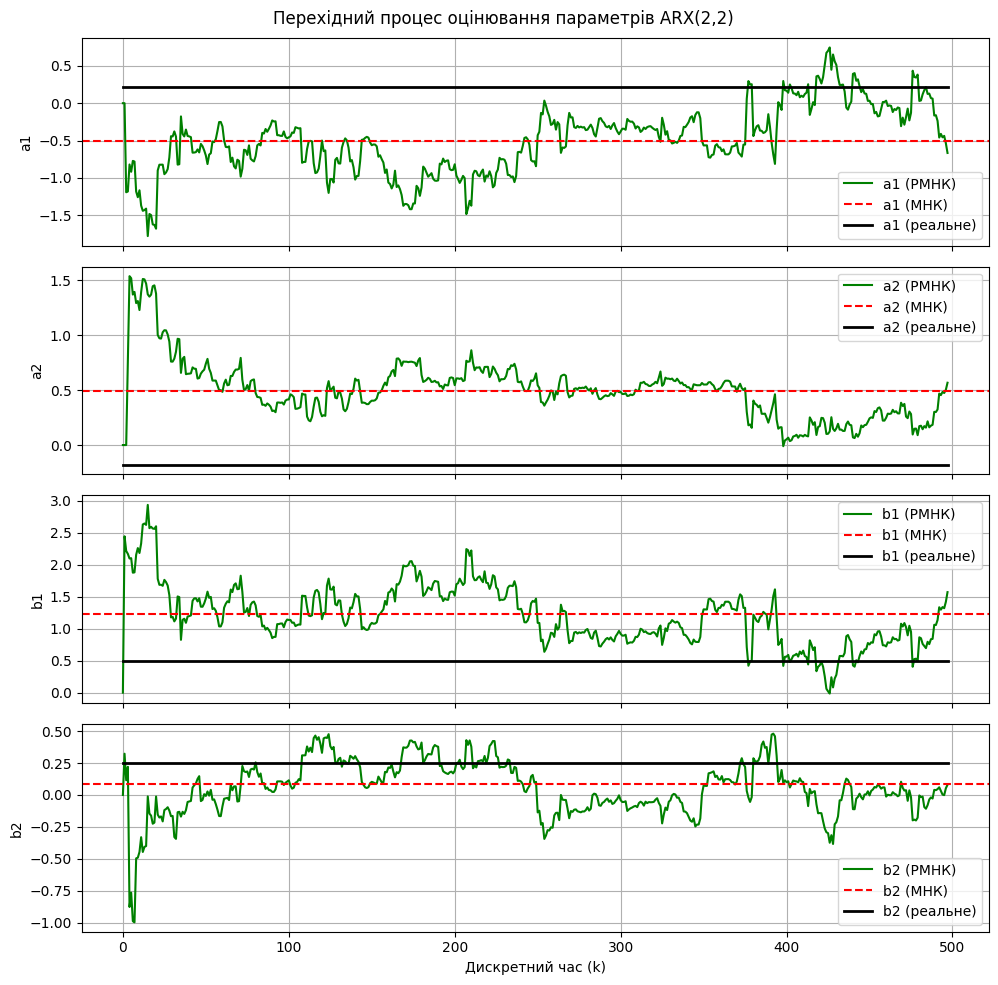

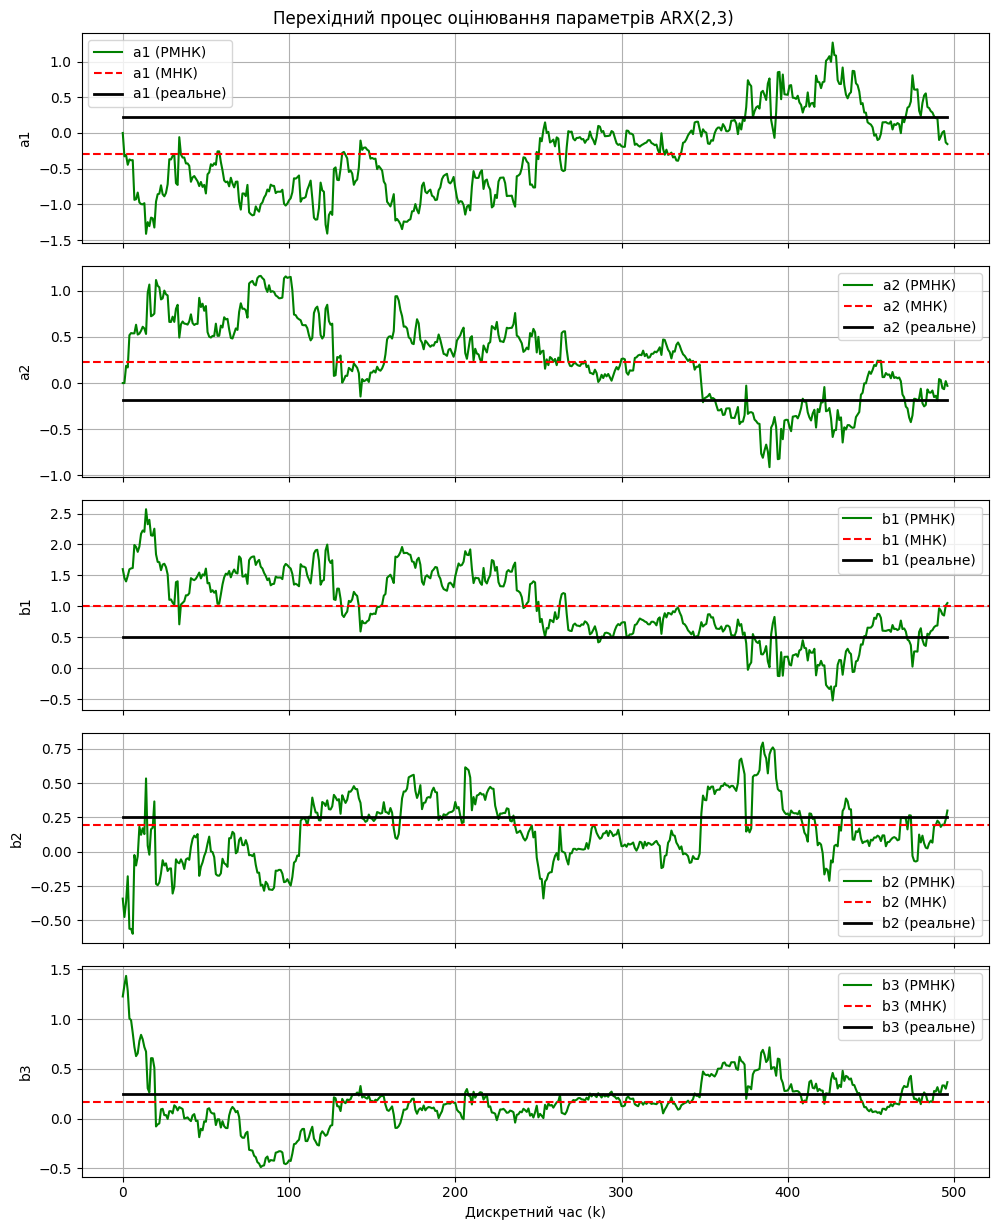

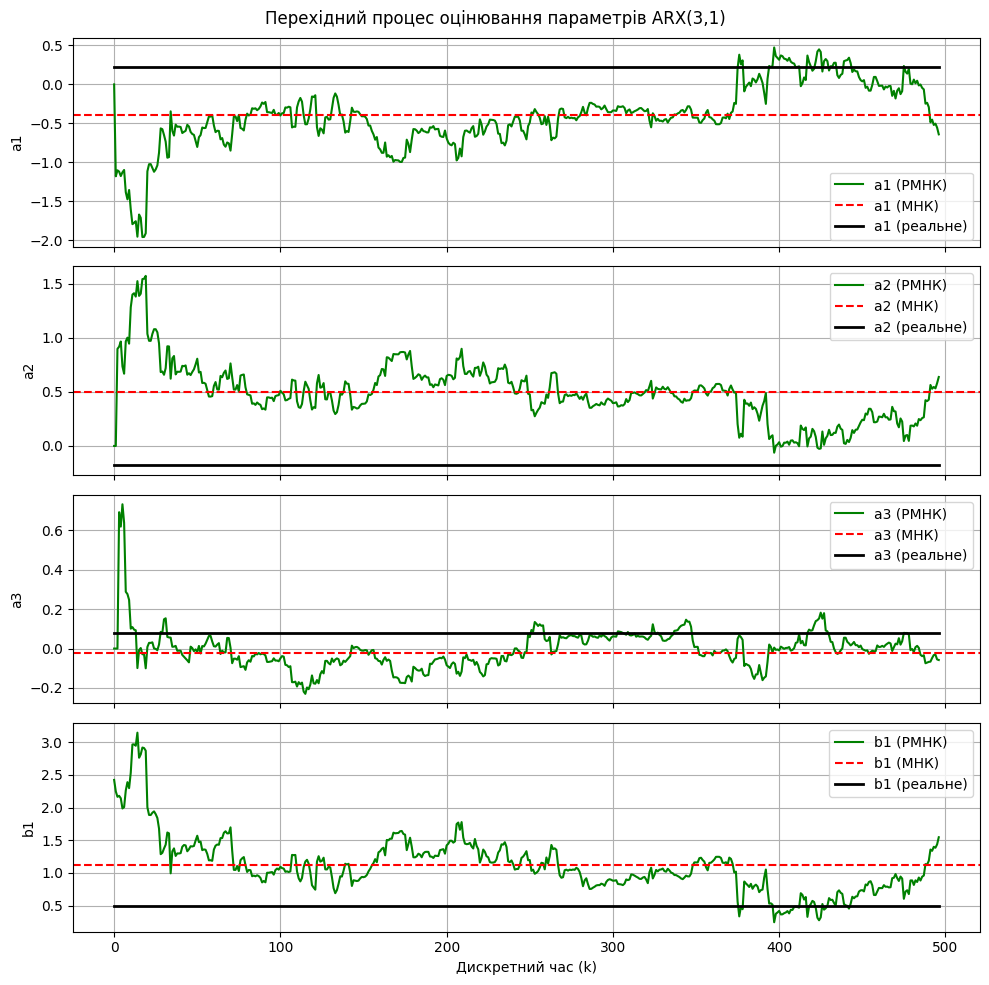

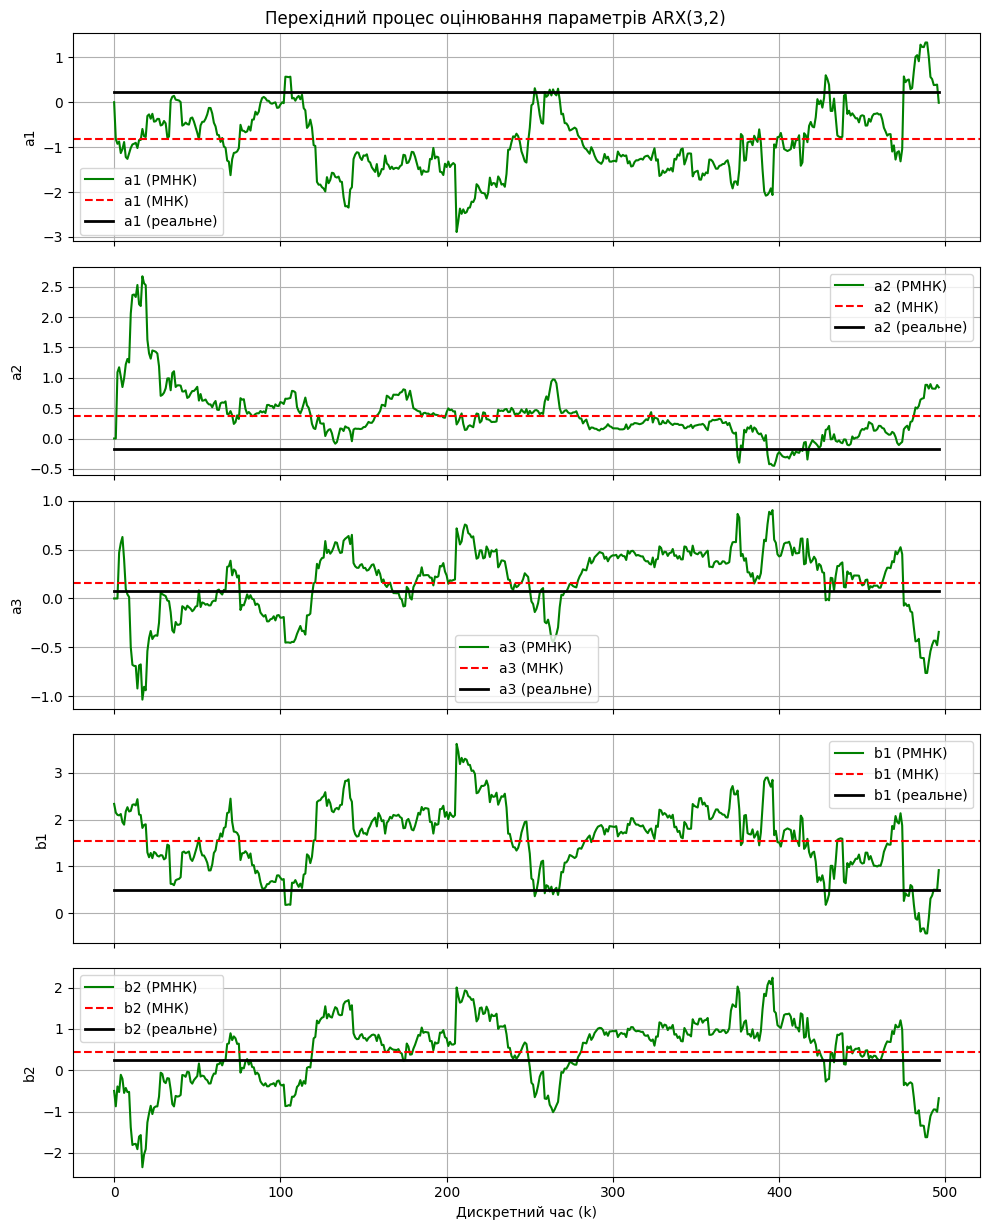

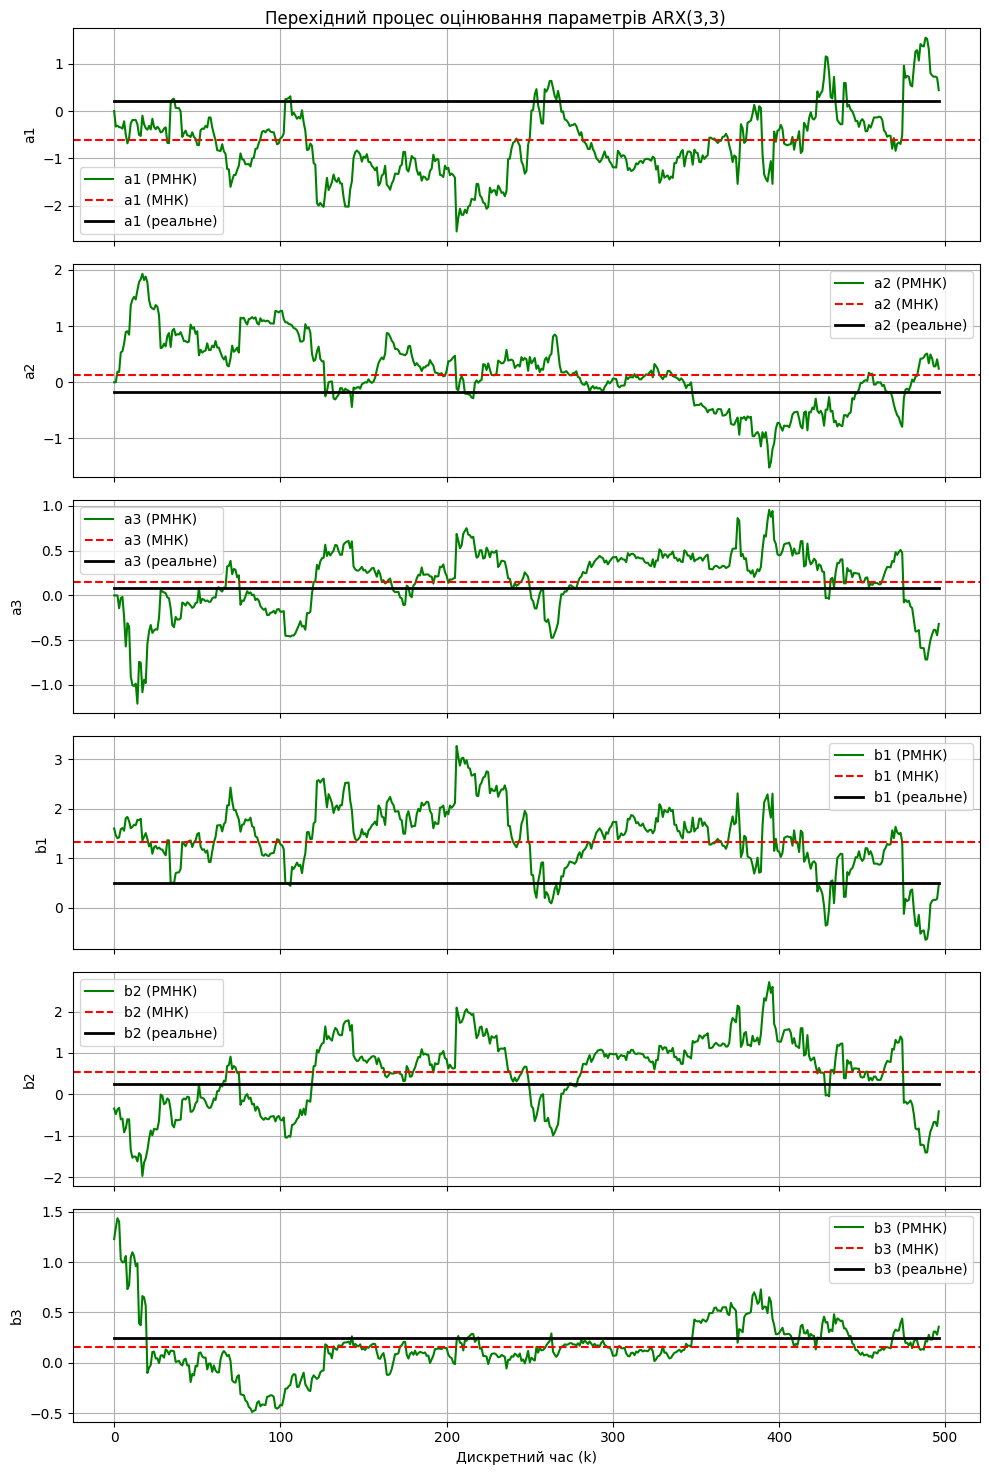

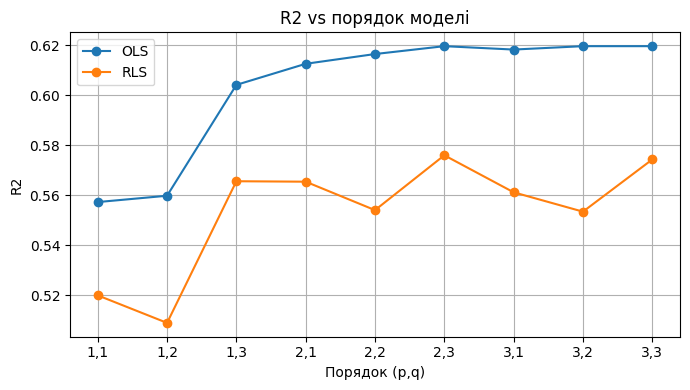

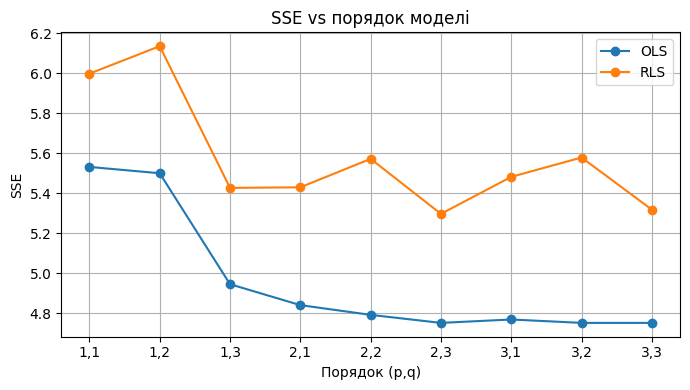

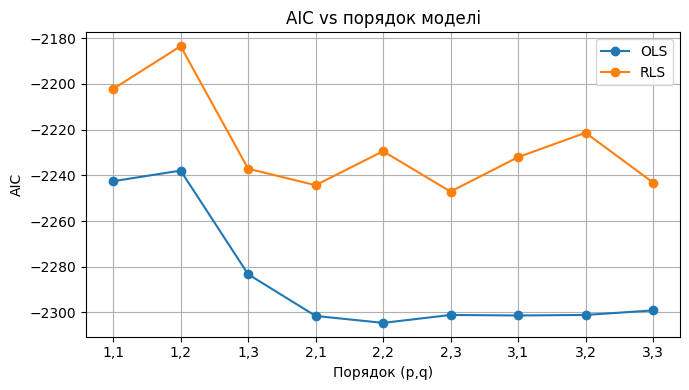


Результати збережені у results_models.xlsx


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# 1. Генерація або завантаження даних
# ----------------------------
def generate_data(n=500, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, 0.1, n)
    y = np.zeros(n)
    # приклад стабільної ARMA(2,2) системи
    a = [0.5, -0.3]
    b = [0.7, -0.2]
    for t in range(max(len(a), len(b)), n):
        y[t] = (a[0]*y[t-1] + a[1]*y[t-2] +
                b[0]*v[t-1] + b[1]*v[t-2] + v[t])
    return y, v

def load_or_generate():
    y_file, v_file = Path("y_generated.txt"), Path("v_generated.txt")
    if y_file.exists() and v_file.exists():
        y = np.loadtxt(y_file)
        v = np.loadtxt(v_file)
    else:
        y, v = generate_data()
        np.savetxt(y_file, y)
        np.savetxt(v_file, v)
        print("Файли не знайдено. Згенеровано синтетичні дані і збережено.")
    return y, v

y, v = load_or_generate()
print(f"Середнє y: {y.mean():.4f}, σ(y): {y.std():.4f}")

# ----------------------------
# 2. Побудова матриці регресорів
# ----------------------------
def design_matrix(y, v, p, q):
    n = len(y)
    m = max(p, q)
    X, Y = [], []
    for t in range(m, n):
        row = []
        # AR частина
        for i in range(1, p+1):
            row.append(y[t-i])
        # MA частина
        for j in range(1, q+1):
            row.append(v[t-j])
        X.append(row)
        Y.append(y[t])
    return np.array(X), np.array(Y)

# ----------------------------
# 3. Методи оцінки
# ----------------------------
def ols_estimation(X, Y):
    theta = np.linalg.lstsq(X, Y, rcond=None)[0]
    y_hat = X @ theta
    e = Y - y_hat
    return theta, e
    

def rls_estimation(X, Y, lam=0.98, delta=1000):
    n_samples, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    thetas = np.zeros((n_samples, n_params))
    errors = np.zeros(n_samples)

    for k in range(n_samples):
        xk = X[k].reshape(-1, 1)
        yk = Y[k]

        # Калманівський крок
        denom = lam + xk.T @ P @ xk
        K = (P @ xk / denom).flatten()

        err = (yk - xk.T @ theta.reshape(-1,1)).item()
        theta = theta + K * err
        P = (P - np.outer(K, xk.T @ P)) / lam

        thetas[k] = theta
        errors[k] = err

    return theta, errors, thetas


# ----------------------------
# 4. Перебір моделей p=1..3, q=1..3
# ----------------------------
results = []
rls_paths = {}  # для перехідних процесів

for p in range(1,4):
    for q in range(1,4):
        X, Y = design_matrix(y, v, p, q)

        # OLS
        th_ols, e_ols = ols_estimation(X, Y)

        # RLS
        th_rls, e_rls, thetas_path = rls_estimation(X, Y)
        rls_paths[(p,q)] = thetas_path

        n = len(Y)
        k = p + q
        sse_ols = np.sum(e_ols**2)
        sse_rls = np.sum(e_rls**2)
        r2_ols = 1 - sse_ols/np.sum((Y - Y.mean())**2)
        r2_rls = 1 - sse_rls/np.sum((Y - Y.mean())**2)
        aic_ols = n*np.log(sse_ols/n) + 2*k
        aic_rls = n*np.log(sse_rls/n) + 2*k

        results.append({
            'p': p, 'q': q,
            'R2_OLS': r2_ols,
            'R2_RLS': r2_rls,
            'SSE_OLS': sse_ols,
            'SSE_RLS': sse_rls,
            'AIC_OLS': aic_ols,
            'AIC_RLS': aic_rls
        })

res_df = pd.DataFrame(results)
print(res_df)


# ----------------------------
# 5. Графіки перехідного процесу РМНК
# ----------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ----------------------------
# 1. Генерація даних для ARX(3,3) (параметри бригади)
# ----------------------------
def generate_data(n=500, seed=42):
    np.random.seed(seed)
    v = np.random.normal(0, 0.1, n)  # шум
    y = np.zeros(n)

    # Параметри (ваші з методички)
    a = [0.22, -0.18, 0.08]   # a1..a3
    b = [0.5, 0.25, 0.25]     # b1..b3

    for t in range(max(len(a), len(b)), n):
        y[t] = sum(a[i] * y[t-i-1] for i in range(len(a)))
        y[t] += sum(b[j] * v[t-j-1] for j in range(len(b)))
        y[t] += v[t]  # поточний шум

    return y, v, a, b

y, v, true_a, true_b = generate_data()

# ----------------------------
# 2. Побудова матриці регресорів
# ----------------------------
def design_matrix(y, v, p, q):
    n = len(y)
    m = max(p, q)
    X, Y = [], []
    for t in range(m, n):
        row = []
        for i in range(1, p+1):  # AR
            row.append(y[t-i])
        for j in range(1, q+1):  # MA
            row.append(v[t-j])
        X.append(row)
        Y.append(y[t])
    return np.array(X), np.array(Y)

# ----------------------------
# 3. Методи оцінки
# ----------------------------
def ols_estimation(X, Y):
    theta = np.linalg.lstsq(X, Y, rcond=None)[0]
    return theta

def rls_estimation(X, Y, lam=0.98, delta=1000):
    n_samples, n_params = X.shape
    theta = np.zeros(n_params)
    P = delta * np.eye(n_params)
    thetas = np.zeros((n_samples, n_params))

    for k in range(n_samples):
        xk = X[k].reshape(-1, 1)
        yk = Y[k]

        # Калманівський крок
        denom = lam + xk.T @ P @ xk
        K = (P @ xk / denom).flatten()
        err = (yk - xk.T @ theta.reshape(-1,1)).item()
        theta = theta + K * err
        P = (P - np.outer(K, xk.T @ P)) / lam

        thetas[k] = theta

    return thetas

# ----------------------------
# 4. Перехідний процес для ARX(3,3)
# ----------------------------
p, q = 3, 3
X, Y = design_matrix(y, v, p, q)
ols_theta = ols_estimation(X, Y)
rls_path = rls_estimation(X, Y)

# Справжні коефіцієнти
true_params = true_a + true_b
labels = [f"a{i+1}" for i in range(p)] + [f"b{j+1}" for j in range(q)]

# ----------------------------
# 5. Побудова графіків
# ----------------------------
def plot_rls_transients_all(y, v, true_a, true_b):
    true_params_by_order = {}
    for p in range(1, 4):
        for q in range(1, 4):
            true_params = true_a[:p] + true_b[:q]
            true_params_by_order[(p, q)] = true_params

    for p in range(1, 4):
        for q in range(1, 4):
            X, Y = design_matrix(y, v, p, q)

            # МНК
            theta_ols = ols_estimation(X, Y)
            
            # РМНК
            thetas_path = rls_estimation(X, Y)

            labels = [f"a{i+1}" for i in range(p)] + [f"b{j+1}" for j in range(q)]
            time = np.arange(thetas_path.shape[0])
            fig, axes = plt.subplots(len(labels), 1, figsize=(10, 2.5 * len(labels)), sharex=True)

            if len(labels) == 1:
                axes = [axes]

            for i, ax in enumerate(axes):
                # РМНК траєкторія
                ax.plot(time, thetas_path[:, i], label=f"{labels[i]} (РМНК)", color="green")

                # МНК оцінка
                if i < len(theta_ols):
                    ax.axhline(theta_ols[i], color="red", linestyle="--", linewidth=1.5,
                               label=f"{labels[i]} (МНК)")

                # Реальне значення
                true_val = true_params_by_order[(p, q)][i]
                ax.plot(time, [true_val] * len(time), color="black", linestyle="-", linewidth=2,
                        label=f"{labels[i]} (реальне)")

                ax.set_ylabel(labels[i])
                ax.grid(True)
                ax.legend(loc="best")

            axes[-1].set_xlabel("Дискретний час (k)")
            fig.suptitle(f"Перехідний процес оцінювання параметрів ARX({p},{q})")
            plt.tight_layout()
            plt.show()

plot_rls_transients_all(y, v, true_a, true_b)


# ----------------------------
# 6. Графіки залежностей R2, SSE, AIC
# ----------------------------
def plot_metric(metric_name):
    plt.figure(figsize=(7,4))
    for method in ['OLS','RLS']:
        vals = []
        orders = []
        for _, r in res_df.iterrows():
            orders.append(f"{int(r.p)},{int(r.q)}")
            vals.append(r[f"{metric_name}_{method}"])
        plt.plot(orders, vals, marker='o', label=method)
    plt.title(metric_name + ' vs порядок моделі')
    plt.xlabel('Порядок (p,q)')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric('R2')
plot_metric('SSE')
plot_metric('AIC')

# Збереження у файл
res_df.to_excel('results_models.xlsx', index=False)
print("\nРезультати збережені у results_models.xlsx")
